**Dependencies**

In [1]:
from DataDownload import *
from PreProcessing import *
from EventIdentification import *
from CataloguedEvents import *
from PostProcessing import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch


**Initiating Parameters For The Day**

In [2]:
# Set date and station for studying423
date = UTCDateTime("2024-04-23") 
station = ['AM','R50D6','https://data.raspberryshake.org']

# Set global earthquake catalogue provider
providers = ["IRIS", "USGS", "EMSC"]

**Download And Read Stream**

In [3]:
stream = download_stream(date, station)
print(stream)

Data for 2024-04-23 already exist.
Reading and loading stream from file.
Stream successfully read.

1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-04-22T23:00:00.004000Z - 2024-04-24T01:00:00.004000Z | 100.0 Hz, 9360001 samples


**Original Stream**

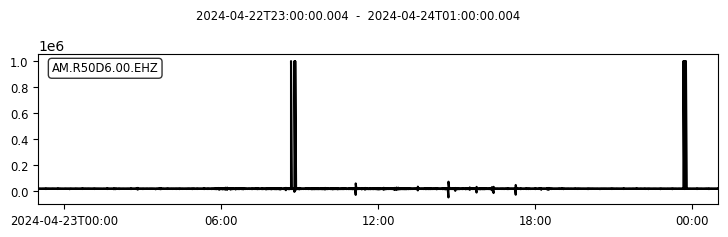

In [4]:
stream.plot()
plt.show()
plt.close()

**Processed Stream(Conventional Methods: Demean, Detrend, Outlier Removal And Band Pass Filtering )**

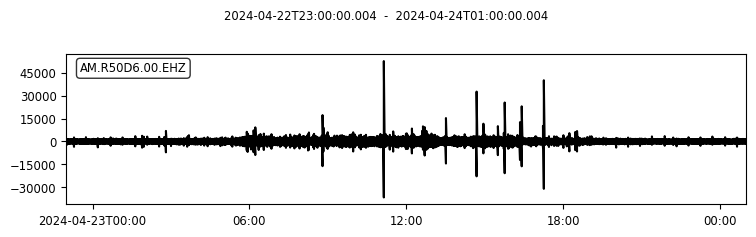

In [5]:
processed_stream = stream_process(stream)

processed_stream.plot()
plt.show()
plt.close()

**Denose Using DeepDenoiser**

Running on GPU


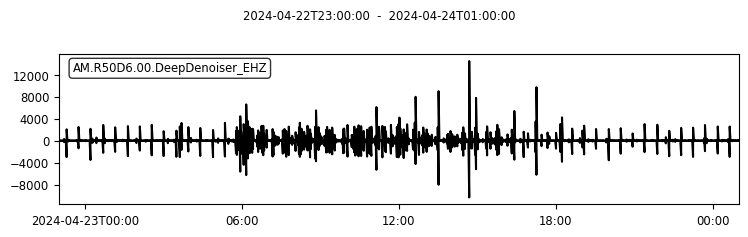

In [6]:
denoiser_model = sbm.DeepDenoiser.from_pretrained("original")

enable_GPU(denoiser_model)

# Denoising the stream using pre-trained model
processed_stream = deep_denoiser(processed_stream, denoiser_model)

processed_stream.plot()
plt.show()
plt.close()

**Performance Testing**

In [7]:
#model_GPD = sbm.GPD.from_pretrained("stead")
#GPD_times = test_model_performance(processed_stream, model_GPD)

In [8]:
#model_PhaseNet = sbm.PhaseNet.from_pretrained("stead")
#PhaseNet_times = test_model_performance(processed_stream, model_PhaseNet)

In [9]:
#model_EQTransformer = sbm.EQTransformer.from_pretrained("original")
#EQTransformer_times = test_model_performance(processed_stream, model_EQTransformer)

**Identify Events Using Pre-trained Deep Learning Model**

In [10]:
# phase_picking_model = sbm.PhaseNet.from_pretrained("stead")
# phase_picking_model = sbm.GPD.from_pretrained("stead")
phase_picking_model = sbm.EQTransformer.from_pretrained("original")
enable_GPU(phase_picking_model)

Running on GPU


In [11]:
df_detected = pretrained_phase_picking(processed_stream, phase_picking_model)
df_detected

,peak_time,peak_confidence,phase
0,2024-04-22T23:01:06.000000Z,0.699751,P
1,2024-04-22T23:01:06.970000Z,0.230014,P
2,2024-04-22T23:01:11.100000Z,0.546595,S
3,2024-04-22T23:01:24.220000Z,0.104990,P
4,2024-04-22T23:02:23.090000Z,0.582725,P
...,...,...,...
1414,2024-04-24T00:37:11.600000Z,0.792976,P
1415,2024-04-24T00:37:12.020000Z,0.557689,S
1416,2024-04-24T00:39:01.340000Z,0.100932,S
1417,2024-04-24T00:50:23.100000Z,0.233178,P


**Using Confidence Score Threshold To Filter Out False Positives**

In [12]:
df_detected = df_detected[df_detected['peak_confidence'] >= 0.7]
df_detected

,peak_time,peak_confidence,phase
6,2024-04-22T23:12:40.960000Z,0.872073,P
8,2024-04-22T23:18:19.110000Z,0.700669,P
13,2024-04-22T23:21:43.220000Z,0.739402,S
15,2024-04-22T23:32:53.070000Z,0.724996,P
33,2024-04-23T00:16:35.020000Z,0.798008,P
...,...,...,...
1374,2024-04-23T22:46:44.760000Z,0.826177,P
1377,2024-04-23T23:14:25.280000Z,0.830160,P
1389,2024-04-23T23:42:06.020000Z,0.895768,P
1413,2024-04-24T00:33:58.880000Z,0.749654,S


**Find Earthquake From Catalogue**

In [13]:
catalogue_path = request_catalogue(
    catalogue_providers= providers,
    coordinates = get_coordinates(station) ,
    date = date,
    radmin=0,
    radmax=90,
    minmag=4,
    maxmag=10,
    overwrite = True
)

catalogue = load_earthquake_catalog(catalogue_path)
print_catalogued(catalogue)

Catalog saved to D:\Dissertation\data\catalogue\2024-04-23_IRIS.xml
Loading catalogue from path.
23 Event(s) in Catalog:
2024-04-23T17:32:51.827000Z | +38.302,  -31.001 | 4.4  mb
2024-04-23T17:12:14.935000Z | +23.752, +121.585 | 4.0  Mwr
...
2024-04-23T00:03:49.290000Z | +23.699, +121.639 | 4.5  mb
2024-04-22T23:35:39.486000Z | +23.814, +121.596 | 4.3  mb
To see all events call 'print(CatalogObject.__str__(print_all=True))'



**Create a DataFrame for Catalogued Events with Predicted Arrival Times**

In [14]:
df_catalogued = create_df_with_prediction(catalogue, get_coordinates(station))
df_catalogued

,time,lat,long,mag,mag_type,P_predict,S_predict,catalogued,detected,P_detected,S_detected
0,2024-04-23T17:32:51.827000,38.3024,-31.0014,4.4,mb,2024-04-23T17:38:26.290187,2024-04-23T17:43:02.274597,True,False,None,None
1,2024-04-23T17:12:14.935000,23.7521,121.5845,4.0,Mwr,2024-04-23T17:25:04.924499,2024-04-23T17:35:48.486855,True,False,None,None
2,2024-04-23T17:01:58.641000,35.5709,140.0758,4.3,mb,2024-04-23T17:14:21.436239,2024-04-23T17:24:40.497552,True,False,None,None
3,2024-04-23T16:02:21.083000,24.0676,121.6927,4.9,mb,2024-04-23T16:15:10.138300,2024-04-23T16:25:52.739126,True,False,None,None
4,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,2024-04-23T15:45:38.589923,2024-04-23T15:50:13.947963,True,False,None,None
5,2024-04-23T13:05:39.336000,50.0999,-28.9704,5.0,mww,2024-04-23T13:09:42.848903,2024-04-23T13:13:21.000711,True,False,None,None
6,2024-04-23T12:40:51.668000,23.7051,121.6597,4.4,Mwr,2024-04-23T12:53:41.595297,2024-04-23T13:04:25.211980,True,False,None,None
7,2024-04-23T12:26:37.914000,41.2925,78.4464,4.7,mb,2024-04-23T12:35:49.112172,2024-04-23T12:43:14.846779,True,False,None,None
8,2024-04-23T12:25:00.682000,83.8816,115.6197,4.4,mb,2024-04-23T12:32:22.870799,2024-04-23T12:38:19.231773,True,False,None,None
9,2024-04-23T09:41:10.126000,25.2385,124.7807,4.5,mb,2024-04-23T09:53:48.993280,2024-04-23T10:04:24.355318,True,False,None,None


**Compare DataFrames And Merge Events Detected In Catalogue**

In [15]:
result_df = match_and_merge(df_catalogued, df_detected, time_tolerance = 10)
print_statistics(result_df)

Detected in Catalogue: 4
Not Detected in Catalogue: 19
Detected but Not in Catalogue: 191



**DataFrame Containing All Events For The Day Categorized**

In [16]:
result_df

,time,lat,long,mag,mag_type,P_predict,S_predict,catalogued,detected,P_detected,S_detected,P_peak_confidence,peak_confidence
0,2024-04-23T17:32:51.827000,38.3024,-31.0014,4.4,mb,2024-04-23T17:38:26.290187,2024-04-23T17:43:02.274597,True,False,None,None,NaN,NaN
1,2024-04-23T17:12:14.935000,23.7521,121.5845,4.0,Mwr,2024-04-23T17:25:04.924499,2024-04-23T17:35:48.486855,True,False,None,None,NaN,NaN
2,2024-04-23T17:01:58.641000,35.5709,140.0758,4.3,mb,2024-04-23T17:14:21.436239,2024-04-23T17:24:40.497552,True,False,None,None,NaN,NaN
3,2024-04-23T16:02:21.083000,24.0676,121.6927,4.9,mb,2024-04-23T16:15:10.138300,2024-04-23T16:25:52.739126,True,True,2024-04-23T16:15:18.970000,None,0.835722,NaN
4,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,2024-04-23T15:45:38.589923,2024-04-23T15:50:13.947963,True,False,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-23T22:46:44.760000,None,NaN,0.826177
210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-23T23:14:25.280000,None,NaN,0.830160
211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-23T23:42:06.020000,None,NaN,0.895768
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,None,2024-04-24T00:33:58.880000,NaN,0.749654


**Visualize Phase Predictions For Successfully Matched Events**

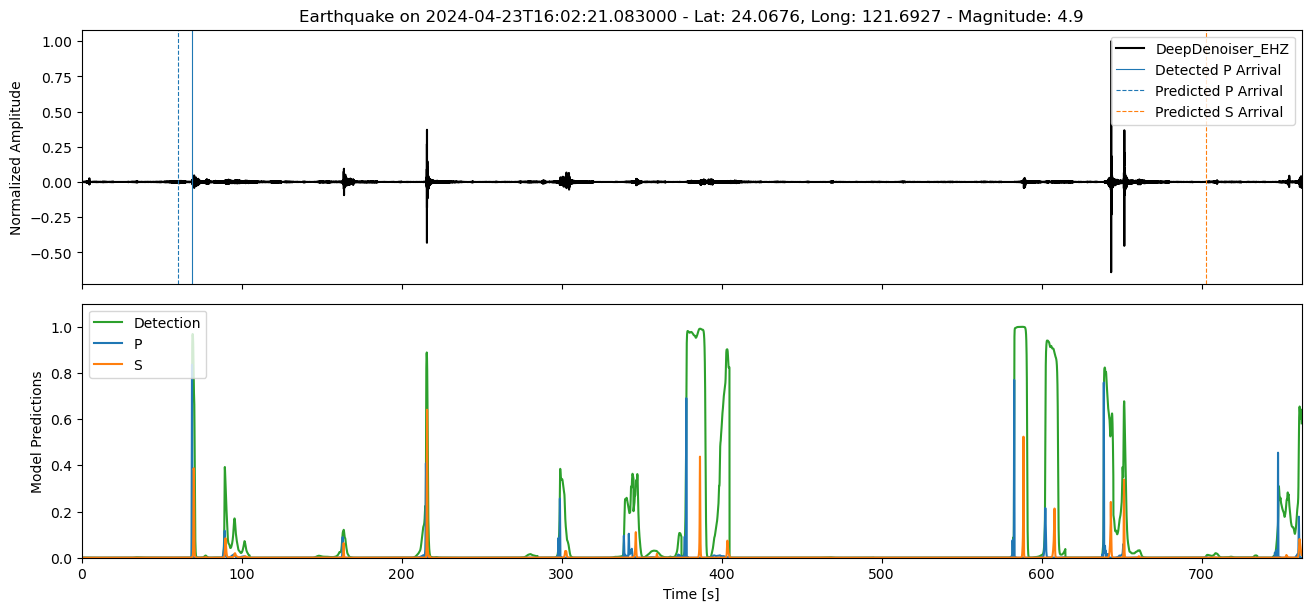

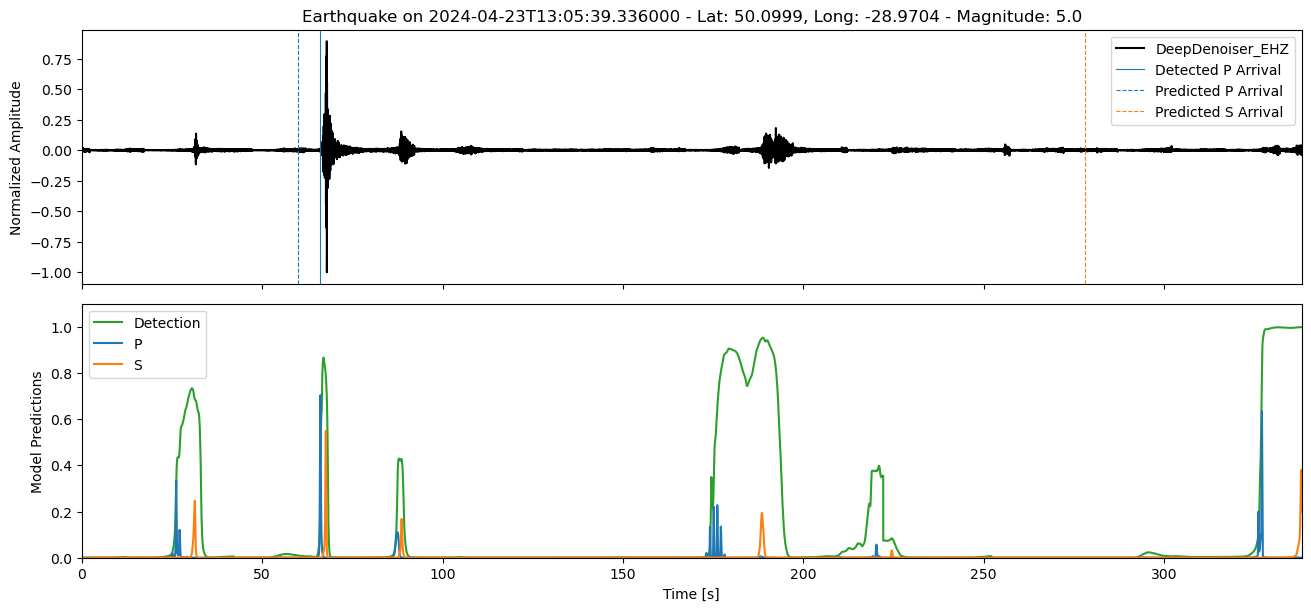

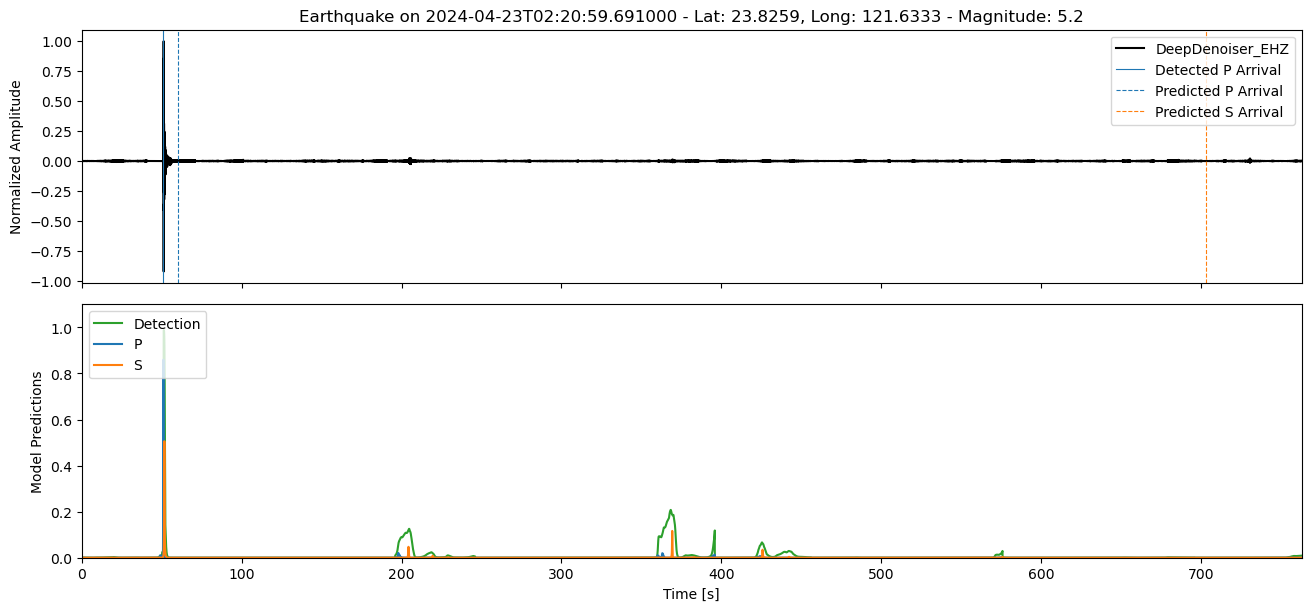

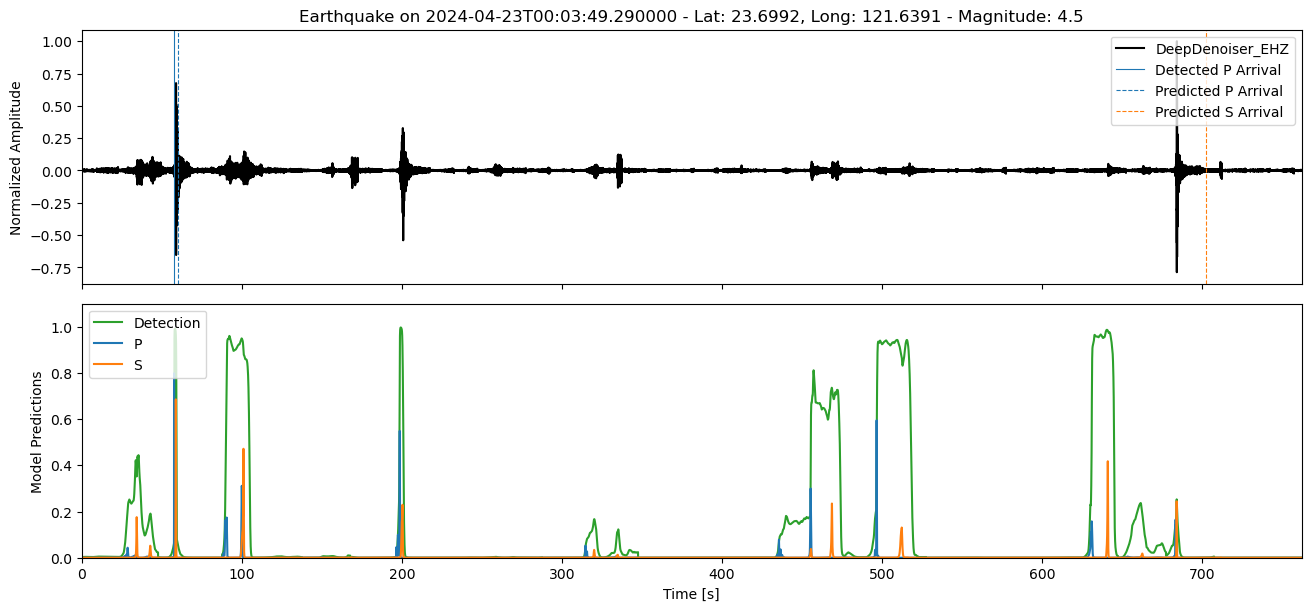

In [17]:
filtered_events = result_df[(result_df['catalogued'] == True) & (result_df['detected'] == True)]
predictions = make_prediction(processed_stream, phase_picking_model)

for _, row in filtered_events.iterrows():
    earthquake_info = get_earthquake_info(row)  # Use the new function to get earthquake info
    trace = create_trace_from_stream(processed_stream, row['P_predict'], row['S_predict'])
    if trace.count() == 0:
        continue
    # plot_with_timestamps(trace[0], row['P_detected'], row['S_detected'], row['P_predict'], row['S_predict'], earthquake_info)
    plot_predictions_wave(trace[0],predictions, row['P_detected'], row['S_detected'], row['P_predict'], row['S_predict'], earthquake_info)

**Information For Successfully Detected Events From Catalogue**

In [18]:
successful_stats(result_df, processed_stream, station)

Earthquake Time: 2024-04-23T16:02:21.083000
Location: Lat 24.0676, Long 121.6927
Magnitude: 4.9 mb
Distance to Station: 9743.51 km
P wave Confidence: 0.8357216715812683
S wave Confidence: None
----------------------------------------
Earthquake Time: 2024-04-23T13:05:39.336000
Location: Lat 50.0999, Long -28.9704
Magnitude: 5.0 mww
Distance to Station: 1921.27 km
P wave Confidence: 0.7034019827842712
S wave Confidence: None
----------------------------------------
Earthquake Time: 2024-04-23T02:20:59.691000
Location: Lat 23.8259, Long 121.6333
Magnitude: 5.2 Mwr
Distance to Station: 9764.02 km
P wave Confidence: 0.8594319820404053
S wave Confidence: None
----------------------------------------
Earthquake Time: 2024-04-23T00:03:49.290000
Location: Lat 23.6992, Long 121.6391
Magnitude: 4.5 mb
Distance to Station: 9776.59 km
P wave Confidence: 0.798008382320404
S wave Confidence: None
----------------------------------------
